<div style="display: flex; background-color: RGB(255,114,0); padding: 30px;" >

# <font color='black'> # Analyse de sentiments </font>

</div>


C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from os import getcwd
import matplotlib.image as mpimg
from nltk.corpus import stopwords, wordnet
from IPython.core.display import HTML
from collections import Counter


In [2]:
import sys
sys.path.append("C:\\Users\\User\\WORK\\workspace-ia\\PERSO\\")
from ara_commons import ara_nlp_function as ara_nlp
from ara_commons.ara_graph import color_graph_background

In [3]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\workspace-ia\\simplon\\2022-02-NLP-Sentiments-analyses\\'

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Les données
</div>

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). 

Il y a trois fichiers textes à importer et à concaténer pour former un dataset avec deux colonnes:
- Une "texte" comportant le contenu du commentaire
- Une "sentiment" comportant une note de 0 ou 1

In [4]:
print("Chargement des données...")
file_name_amazon_label = "amazon_cells_labelled.txt"
file_name_imdb_labelled = "imdb_labelled.txt"
file_name_yelp_labelled = 'yelp_labelled.txt'

df_origin_amazon_label = pd.read_csv(file_path+"\\data\\"+file_name_amazon_label, sep='\t', header=None)
df_origin_imdb_labelled = pd.read_csv(file_path+"\\data\\"+file_name_imdb_labelled, sep='\t', header=None)
df_origin_yelp_labelled= pd.read_csv(file_path+"\\data\\"+file_name_yelp_labelled, sep='\t', header=None)

print("Chargement des données", df_origin_amazon_label.shape, df_origin_imdb_labelled.shape,  df_origin_yelp_labelled.shape, ".......................................... END")

Chargement des données...
Chargement des données (1000, 2) (748, 2) (1000, 2) .......................................... END


In [5]:
df_origin_amazon_label.head()

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [6]:
df_origin_amazon_label["website"] = "amazon"
df_origin_imdb_labelled["website"] = "imdb"
df_origin_yelp_labelled["website"] = "yelp"

In [7]:
df_origin_full = df_origin_amazon_label.append(df_origin_imdb_labelled)
df_origin_full = df_origin_full.append(df_origin_yelp_labelled)
print(df_origin_full.shape)
df_origin_full.head()

(2748, 3)


,0,1,website
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon


In [8]:
df_origin_full = df_origin_full.rename(columns={0: "sentence", 1: "connotation"})
df_origin_full.columns

Index(['sentence', 'connotation', 'website'], dtype='object')

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Exploration des données: 
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Questions préalables: 
</div>

- Quelle est la taille du dataset ?
- Comment est distribuée la variable sentiment ?

In [9]:
df_origin_full.shape

(2748, 3)

In [10]:
df_origin_full["connotation"].value_counts()

1    1386
0    1362
Name: connotation, dtype: int64

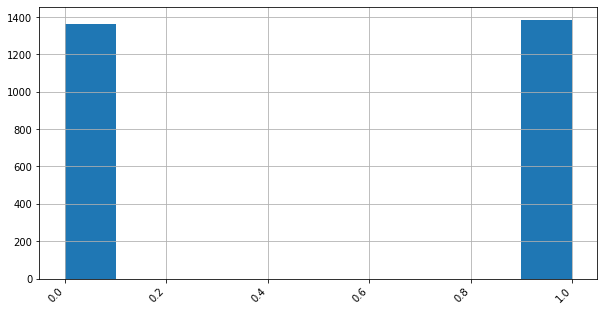

In [11]:
figure, axes = color_graph_background(1, 1)

df_origin_full.connotation.hist()

figure.set_size_inches(10, 5, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

In [12]:
df_origin_full.columns

Index(['sentence', 'connotation', 'website'], dtype='object')

In [13]:
df_origin_full["connotation_label"] = np.nan
df_origin_full.loc[df_origin_full['connotation'] == 0, 'connotation_label'] = "negativ"
df_origin_full.loc[df_origin_full['connotation'] == 1, 'connotation_label'] = "positiv"
df_origin_full

,sentence,connotation,website,connotation_label
0,So there is no way for me to plug it in here i...,0,amazon,negativ
1,"Good case, Excellent value.",1,amazon,positiv
2,Great for the jawbone.,1,amazon,positiv
3,Tied to charger for conversations lasting more...,0,amazon,negativ
4,The mic is great.,1,amazon,positiv
...,...,...,...,...
995,I think food should have flavor and texture an...,0,yelp,negativ
996,Appetite instantly gone.,0,yelp,negativ
997,Overall I was not impressed and would not go b...,0,yelp,negativ
998,"The whole experience was underwhelming, and I ...",0,yelp,negativ


In [14]:
df_group = df_origin_full.groupby(["website", "connotation_label"], as_index=True)['connotation'].count()
df_group

website  connotation_label
amazon   negativ              500
         positiv              500
imdb     negativ              362
         positiv              386
yelp     negativ              500
         positiv              500
Name: connotation, dtype: int64

In [15]:
df_group_ri = df_group.reset_index()
df_group_ri

,website,connotation_label,connotation
0,amazon,negativ,500
1,amazon,positiv,500
2,imdb,negativ,362
3,imdb,positiv,386
4,yelp,negativ,500
5,yelp,positiv,500


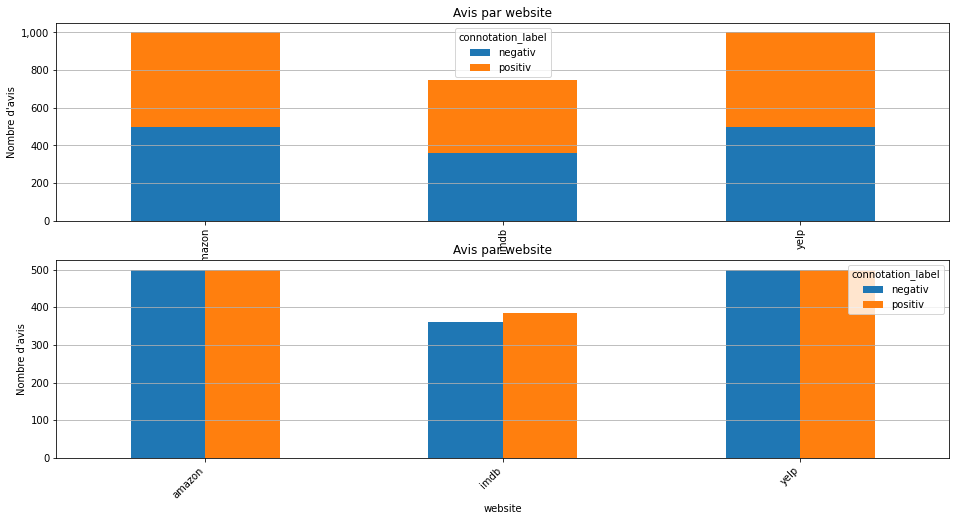

In [16]:
df_group = df_origin_full.groupby(["website", "connotation_label"])['connotation'].count().unstack('connotation_label').fillna(0)
figure, axes = color_graph_background(2, 1)

axe = axes[0]
df_group.plot(kind='bar', stacked=True, title="Avis par website", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nombre d'avis")
axe.grid(axis='y')

axe = axes[1]
df_group.plot(kind='bar', stacked=False, title="Avis par website", ax=axe)
axe.yaxis.set_major_formatter(FuncFormatter(lambda x, p: "{:,.0f}". format(x)))
axe.set_ylabel("Nombre d'avis")
axe.grid(axis='y')

figure.set_size_inches(16, 8, forward=True)
plt.xticks(rotation=45, ha="right")
plt.show()

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Pré-processing
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Question 1: Combien y a t'il de mots dans l'ensemble du corpus ? Sont-ils "homogènes" ? 
</div>

### Import du module permettant le traitement de texte: nltk

In [17]:
print(df_origin_full.shape)
df_origin_full.columns

(2748, 4)


Index(['sentence', 'connotation', 'website', 'connotation_label'], dtype='object')

In [18]:
df_nlp = df_origin_full[['website','connotation_label', 'connotation', 'sentence']]
print(df_nlp.shape)
print(df_nlp.columns)
df_nlp

(2748, 4)
Index(['website', 'connotation_label', 'connotation', 'sentence'], dtype='object')


,website,connotation_label,connotation,sentence
0,amazon,negativ,0,So there is no way for me to plug it in here i...
1,amazon,positiv,1,"Good case, Excellent value."
2,amazon,positiv,1,Great for the jawbone.
3,amazon,negativ,0,Tied to charger for conversations lasting more...
4,amazon,positiv,1,The mic is great.
...,...,...,...,...
995,yelp,negativ,0,I think food should have flavor and texture an...
996,yelp,negativ,0,Appetite instantly gone.
997,yelp,negativ,0,Overall I was not impressed and would not go b...
998,yelp,negativ,0,"The whole experience was underwhelming, and I ..."


In [19]:
def nlp_pre_process(input, string_expected=True, sw=None, sw_language=None, ngram=(1,1), verbose=0):
    res = []
    # ce traitement n'est fait qu'une fois, même si l'on appelle en récurcif la méthode
    if sw_language :
        if sw is None:
            sw = stopwords.words(sw_language)
        else :
            sw.extend(stopwords.words(sw_language))

    if isinstance(input, list):
        res = [' '.join(nlp_pre_process(sentence, string_expected=string_expected, sw=sw, ngram=ngram)) for sentence in input]
    elif isinstance(input, str):
        res = ara_nlp.ara_tokenize(input)
        res = ara_nlp.remove_english_stopwords_func(res, sw)
        res = ara_nlp.normalize_accented_chars(res)
        res = ara_nlp.remove_irr_char_func(res)
        # res = ara_nlp.norm_lemm_a_func(res, is_text_list=True)
        # res = ara_nlp.remove_types_on_tokens(res, types_to_keep=[wordnet.ADJ,wordnet.NOUN], verbose=verbose)
        res = ara_nlp.norm_lemm_func(res, auto_type=True, is_text_list=True)
        # res = ara_nlp.remove_types_on_tokens(res, types_to_keep=[wordnet.ADJ,wordnet.NOUN], verbose=verbose)
        res = ara_nlp.remove_english_stopwords_func(res, sw)
        if ngram is not None and (ngram[0] > 1 or ngram[1]>1):
            res = ara_nlp.ara_ngrams(res, min_n=ngram[0], max_n=ngram[1], pas_n=1, verbose=verbose, is_token=True)
    res = list(filter(None, res))
    if string_expected:
        res = ' '.join(res)
    return res

#### Consigne 1: Récupérer le corpus de mots sans la ponctuation ni les stopwords

In [20]:
personnal_stop_word = []

In [21]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
df_nlp["words"] = df_nlp["sentence"].apply(lambda x: nlp_pre_process(x, string_expected=False, sw=personnal_stop_word, sw_language="english"))
display(HTML(df_nlp.head().to_html()))

,website,connotation_label,connotation,sentence,words
0,amazon,negativ,0,So there is no way for me to plug it in here in the US unless I go by a converter.,"[way, plug, u, unless, go, converter]"
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]"
2,amazon,positiv,1,Great for the jawbone.,"[great, jawbone]"
3,amazon,negativ,0,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,"[tie, charger, conversation, last, minute, major, problem]"
4,amazon,positiv,1,The mic is great.,"[mic, great]"


<div style="display: flex; background-color: Green; padding: 7px;" >

### Question 2: Combien de mots restent-ils ? 
</div>

In [23]:
df_nlp["nb_old_words"] = df_nlp["sentence"].apply(lambda x: len(x.split()))
df_nlp["nb_words"] = df_nlp["words"].apply(lambda x: len(x))

In [24]:
display(HTML(df_nlp.head(20).to_html()))

,website,connotation_label,connotation,sentence,words,nb_old_words,nb_words
0,amazon,negativ,0,So there is no way for me to plug it in here in the US unless I go by a converter.,"[way, plug, u, unless, go, converter]",21,6
1,amazon,positiv,1,"Good case, Excellent value.","[good, case, excellent, value]",4,4
2,amazon,positiv,1,Great for the jawbone.,"[great, jawbone]",4,2
3,amazon,negativ,0,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,"[tie, charger, conversation, last, minute, major, problem]",11,7
4,amazon,positiv,1,The mic is great.,"[mic, great]",4,2
5,amazon,negativ,0,I have to jiggle the plug to get it to line up right to get decent volume.,"[jiggle, plug, get, line, right, get, decent, volume]",17,8
6,amazon,negativ,0,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.","[several, dozen, several, hundred, contact, imagine, fun, send, one, one]",21,10
7,amazon,positiv,1,If you are Razr owner...you must have this!,"[razr, owner, must]",8,3
8,amazon,negativ,0,"Needless to say, I wasted my money.","[needle, say, waste, money]",7,4
9,amazon,negativ,0,What a waste of money and time!.,"[waste, money, time]",7,3


<mark> Attention : les négations ont disparue, ce qui change le sens des phrases</mark>

In [25]:
nb_old_w = df_nlp["nb_old_words"].sum()
nb_w = df_nlp["nb_words"].sum()
print(f"nb_old_words : {nb_old_w}, nb_words : {nb_w}")

nb_old_words : 35742, nb_words : 18010


Graphe général

18010 words


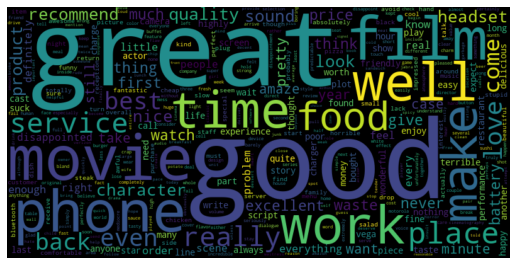

In [31]:
temp = list(df_nlp["words"])
ing_list = []
for igs in temp:
    for ig in igs:
        ing_list.append(ig)
if verbose:
    print(ing_list)
print(len(ing_list), "words")
ara_nlp.draw_word_cloud(ing_list)

In [32]:
dict_texte = dict(Counter(ing_list).most_common())
dict_texte

{'good': 231,
 'great': 215,
 'movie': 212,
 'film': 189,
 'phone': 178,
 'bad': 157,
 'one': 149,
 'work': 145,
 'well': 145,
 'like': 144,
 'time': 134,
 'go': 129,
 'make': 128,
 'food': 127,
 'place': 126,
 'get': 120,
 'service': 110,
 'really': 103,
 'use': 89,
 'would': 87,
 'love': 87,
 'even': 79,
 'best': 78,
 'ever': 76,
 'see': 76,
 'also': 74,
 'back': 74,
 'come': 71,
 'quality': 67,
 'look': 63,
 'recommend': 61,
 'say': 60,
 'character': 59,
 'product': 57,
 'sound': 56,
 'headset': 55,
 'nice': 55,
 'excellent': 53,
 'could': 53,
 'price': 53,
 'thing': 53,
 'watch': 53,
 'never': 52,
 'think': 51,
 'much': 50,
 'give': 50,
 'way': 48,
 'battery': 48,
 'act': 48,
 'waste': 47,
 'first': 47,
 'pretty': 43,
 'try': 43,
 'ear': 41,
 'year': 41,
 'take': 40,
 'case': 39,
 'still': 39,
 'minute': 38,
 'amaze': 38,
 'want': 37,
 'everything': 37,
 'end': 37,
 'order': 37,
 'enough': 36,
 'feel': 36,
 'know': 36,
 'two': 35,
 'little': 35,
 'disappointed': 35,
 'every': 35,
 

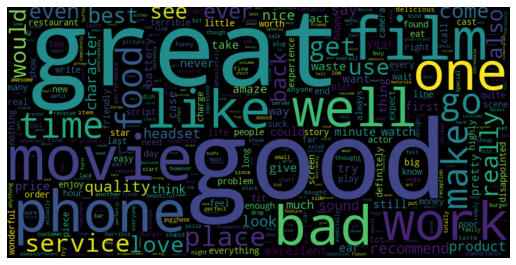

In [33]:
ara_nlp.draw_word_cloud(texte=dict_texte)

Graphe par site web

In [26]:
websites = df_nlp["website"].unique()
websites

array(['amazon', 'imdb', 'yelp'], dtype=object)

5165 words for  amazon
7372 words for  imdb
5473 words for  yelp


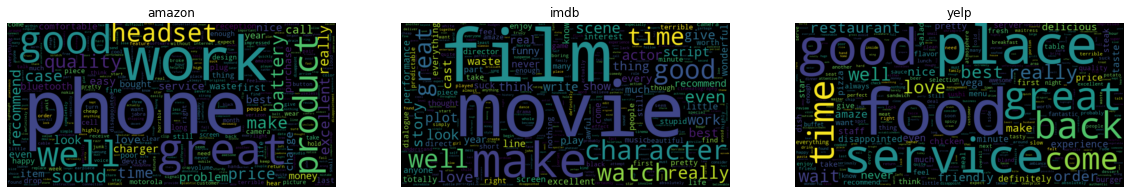

In [30]:
fig, ax = color_graph_background(1,len(websites))

i = 0
for site in websites:
    temp = list(df_nlp.loc[df_nlp["website"]==site,"words"])
    ing_list = []
    for igs in temp:
        for ig in igs:
            ing_list.append(ig)
    if verbose:
        print(ing_list)
    print(len(ing_list), "words for ", site)
    ara_nlp.draw_word_cloud(ing_list, ax=ax[i])
    ax[i].set_title(site)
    i += 1

fig.set_size_inches(20, 15, forward=True)
# plt.xticks(rotation=45, ha="right")
plt.show()

<div style="display: flex; background-color: Green; padding: 7px;" >

### Question 2: Combien de mots restent-ils ? 
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 1 : approche td-idf
</div>

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*.

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 2: Utiliser OneHotEncoder ou CountVectorizer pour représenter les données sous forme d'une matrice contenant autant de colonnes que de mots dans le corpus
</div>

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 3: lancer un modèle de classification pour prédire les sentiments de 30% des observations
</div>

*   Séparer échantillon train / test
*   Entrainer un modèle de classification
*   Afficher la matrice de confusion
*   Calculer l'accuracy, la précision et le recall
*   Votre modèle est-il soumis à un overfitting ?

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 4: Utiliser TF-IDF pour représenter les données et relancer un modèle de classification
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 2 : word2vec
</div>

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity).

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 5: Utiliser Word2vec pour représenter les données et relancer un modèle de classification
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# Exercice 3 : Comparer les deux approches
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 6: Faire un graphique montrant les courbes ROC associées au deux modèles
</div>

<div style="display: flex; background-color: Green; padding: 7px;" >

### Consigne 7: Faire un graphique montrant les courbes Precision-Recall associées aux deux modèles
</div>

<div style="display: flex; background-color: Blue; padding: 15px;" >

# BONUS: reprendre l'étape de One_hot_encoding et ajouter une étape de réduction de dimension (type ACP)
</div>

In [ ]:
import nltk
import os
from tools import ap

def format_sentence(sent):
    return ({ word: True for word in nltk.word_tokenize(sent.decode('utf-8')) })


def load_training_set():
    training = []

    for fp in os.listdir(ap('aclImdb/train/pos')):
        example = '{}/{}'.format(ap('aclImdb/train/pos'), fp)
        with open(example) as fp:
            for i in fp:
                training.append([format_sentence(i), 'pos'])

    for fp in os.listdir(ap('aclImdb/train/neg')):
        example = '{}/{}'.format(ap('aclImdb/train/neg'), fp)
        with open(example) as fp:
            for i in fp:
                training.append([format_sentence(i), 'neg'])

    return training

training = load_training_set()

In [ ]:
training[:3]

In [ ]:
from nltk.classify import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(training)

In [ ]:
classifier.show_most_informative_features(n=25)